# Middle-Truncation for Data
The goal of this notebook is to identify how best we can truncate the data to preserve PII labels. Truncating the end is not effective, because PII labels are likely to appear at the beginning and end, so cutting out the middle is generally better. Ultimately, if the capacity of the model is MAX_LENGTH tokens, we would like to find optimal k to truncate the data to retain the first k tokens and the last MAX_LENGTH - k tokens 

# Load data
Paths will need to be changed if not running file on kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv
/kaggle/input/pii-detection-removal-from-educational-data/train.json
/kaggle/input/pii-detection-removal-from-educational-data/test.json


In [2]:
!pip install seqeval evaluate -q
import json
import argparse
from itertools import chain
from functools import partial
import torch
from transformers import AutoTokenizer,AutoModelForTokenClassification,Trainer, TrainingArguments, AutoConfig, DataCollatorForTokenClassification, TrainerCallback
import evaluate
from datasets import Dataset, features
import copy

2024-05-02 16:20:16.739123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 16:20:16.739233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 16:20:16.862140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the data into dataframe df
data = json.load(open('/kaggle/input/pii-detection-removal-from-educational-data/train.json'))
NUM_TEXTS = len(data)

# create Dataset object from the data dict
df = pd.DataFrame(data)
df['provided_labels'] = df['labels']
df = df.drop(columns = ['labels'])
print(df.columns)
ds = Dataset.from_pandas(df)

Index(['document', 'full_text', 'tokens', 'trailing_whitespace',
       'provided_labels'],
      dtype='object')


In [4]:
LABELS = ['I-ID_NUM', 'O', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'B-NAME_STUDENT', 'B-EMAIL', 'B-ID_NUM', 
          'B-USERNAME', 'B-PHONE_NUM', 'I-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'I-NAME_STUDENT']
label2id = {l:i for i, l in enumerate(LABELS)}
id2label = {i:l for i, l in enumerate(LABELS)}
label2id

{'I-ID_NUM': 0,
 'O': 1,
 'I-STREET_ADDRESS': 2,
 'I-URL_PERSONAL': 3,
 'B-NAME_STUDENT': 4,
 'B-EMAIL': 5,
 'B-ID_NUM': 6,
 'B-USERNAME': 7,
 'B-PHONE_NUM': 8,
 'I-PHONE_NUM': 9,
 'B-STREET_ADDRESS': 10,
 'B-URL_PERSONAL': 11,
 'I-NAME_STUDENT': 12}

# Tokenize data

In [5]:
# This requires us to rebuild the text so that each label is associated with each character rather than the token itself
def reconstruct(batch): 
    text = []
    labels = []
    
    for t, l, ws in zip(
        batch["tokens"], batch["provided_labels"], batch["trailing_whitespace"]):
            
            text.append(t)
            labels.extend([l]*len(t))
            
            if ws: 
                text.append(" ")
                labels.append("O")
                
    return "".join(text),np.array(labels)

def tokenize(batch, tokenizer):
    
    text,labels = reconstruct(batch)
    
    # Tokenize with pre-trained tokenizer
    #tokenized = tokenizer(text, return_offsets_mapping=True, max_length=TRAINING_MAX_LENGTH)
    tokenized = tokenizer(text, return_offsets_mapping=True)
    
    # Create labels for each token 
    token_labels = []
    
    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

In [6]:
def find_percentage(ls, cutoff, MAX_LENGTH): 
    length = len(ls)
    count = length - ls.count(1)
    if ((length > MAX_LENGTH) & (count>0)): 
        labels_truncated = ls[:cutoff] + ls[-(MAX_LENGTH-cutoff):]
        truncated_count = MAX_LENGTH - labels_truncated.count(1)
        return (truncated_count / count)
    else: 
        return 1

# RoBERTa cutoffs

In [7]:
# Model Settings from Hugging Face: Path, Length, Output Directory
TRAINING_MODEL_PATH = "FacebookAI/roberta-base"
TRAINING_MAX_LENGTH = 512
OUTPUT_DIR = "output"

# TOKENIZE the text into tokens and their corresponding labels
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

# tokenize ds
ds = ds.map(tokenize, 
            fn_kwargs={'tokenizer':tokenizer},
            num_proc=3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=3):   0%|          | 0/6807 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Token indices sequence length is longer than the specified maximum sequence length for this model (835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1262 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [8]:
token_labels = ds['labels']
short_token_labels = token_labels
cutoffs = np.arange(0, TRAINING_MAX_LENGTH, 1)
n = len(cutoffs)
length = len(short_token_labels)
cutoff_stat_roberta = np.zeros(n)
i = 0
for c in cutoffs: 
    cutoff_mean = 0
    for ls in short_token_labels: 
        cutoff_mean += find_percentage(ls, c, TRAINING_MAX_LENGTH)
    cutoff_stat_roberta[i] = cutoff_mean / length
    i += 1

print(cutoff_stat_roberta)

[0.9083239  0.90831065 0.91467767 0.92108293 0.92660561 0.93158668
 0.93490549 0.93737427 0.94078059 0.94465677 0.94843199 0.95225721
 0.95621923 0.95976745 0.963018   0.96592683 0.9684978  0.97078562
 0.97275837 0.9744649  0.97604079 0.97737481 0.97819677 0.97870586
 0.97915514 0.97980357 0.98063345 0.98145683 0.98196836 0.98240097
 0.98290889 0.98347733 0.98391258 0.98438694 0.9848182  0.98510752
 0.98539762 0.98580177 0.9860884  0.98623082 0.98641987 0.98658549
 0.98682491 0.98698991 0.98707831 0.98712101 0.98715659 0.98722563
 0.98734387 0.98742777 0.98752847 0.98763048 0.98771551 0.98773459
 0.98777424 0.98789225 0.98802328 0.98819255 0.98823776 0.98825369
 0.98829805 0.98830504 0.98825967 0.98822817 0.98820427 0.98822584
 0.98825853 0.98826473 0.98828963 0.9882946  0.9883052  0.98829255
 0.98828495 0.98827519 0.98844033 0.98841854 0.98843396 0.98841792
 0.98839709 0.98842235 0.98841997 0.98841468 0.98844967 0.98848129
 0.98852035 0.9885764  0.98862756 0.98863535 0.98865606 0.9886

# DeBERTa cutoffs

In [9]:
# Model Settings from Hugging Face: Path, Length, Output Directory
TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
OUTPUT_DIR = "output"

# TOKENIZE the text into tokens and their corresponding labels
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

# tokenize ds
ds = ds.map(tokenize, 
            fn_kwargs={'tokenizer':tokenizer},
            num_proc=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map (num_proc=3):   0%|          | 0/6807 [00:00<?, ? examples/s]

In [10]:
TRAINING_MAX_LENGTH = 1024
token_labels = ds['labels']
short_token_lables = token_labels
cutoffs = np.arange(0, TRAINING_MAX_LENGTH, 1)
n = len(cutoffs)
length = len(short_token_labels)
cutoff_stat_deberta = np.zeros(n)
i = 0
for c in cutoffs: 
    cutoff_mean = 0
    for ls in short_token_labels: 
        cutoff_mean += find_percentage(ls, c, TRAINING_MAX_LENGTH)
    cutoff_stat_deberta[i] = cutoff_mean / length
    i += 1

print(cutoff_stat_deberta)


[0.96924678 0.96913157 0.97139176 ... 0.99331487 0.99294376 0.99294665]


In [11]:
TRAINING_MAX_LENGTH = 2048
cutoffs = np.arange(0, TRAINING_MAX_LENGTH, 1)
n = len(cutoffs)
length = len(short_token_labels)
cutoff_stat_deberta_long = np.zeros(n)
i = 0
for c in cutoffs: 
    cutoff_mean = 0
    for ls in short_token_labels: 
        cutoff_mean += find_percentage(ls, c, TRAINING_MAX_LENGTH)
    cutoff_stat_deberta_long[i] = cutoff_mean / length
    i += 1

print(cutoff_stat_deberta_long)

[0.99738531 0.99738531 0.99757679 ... 0.99953076 0.99952026 0.99952799]


# Analyze all cutoffs

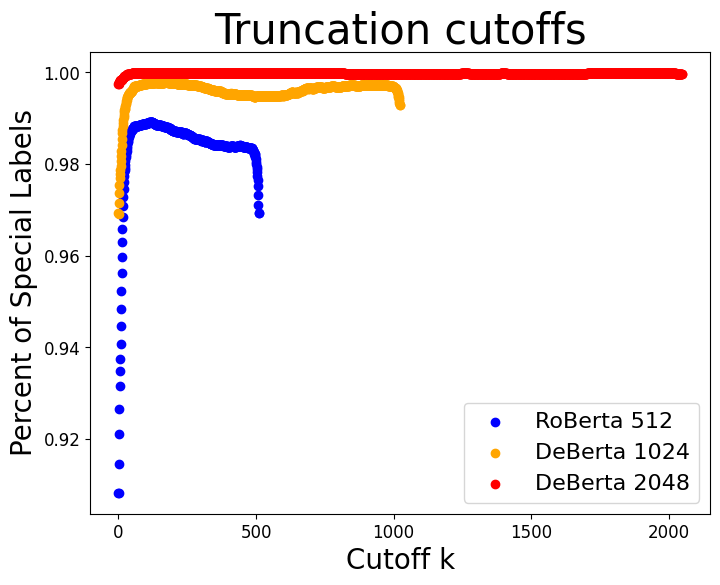

In [12]:
# importing the required module
import matplotlib.pyplot as plt
 
plt.figure(figsize=(8,6))

plt.scatter(np.arange(0, 512, 1),
               cutoff_stat_roberta, 
           c = 'blue')
plt.scatter(np.arange(0, 1024, 1),
               cutoff_stat_deberta, 
           c = 'orange')
plt.scatter(np.arange(0, 2048, 1),
               cutoff_stat_deberta_long, 
           c = 'red')
plt.title("Truncation cutoffs", fontsize = 30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Cutoff k", fontsize = 20)
plt.ylabel("Percent of Special Labels", fontsize = 20)
plt.legend(["RoBerta 512" , "DeBerta 1024", "DeBerta 2048"], fontsize = 16)

plt.savefig('foo.pdf')
plt.show()


In [13]:
index_d = np.argmax(cutoff_stat_deberta)
index_r = np.argmax(cutoff_stat_roberta)
index_dl = np.argmax(cutoff_stat_deberta)

In [14]:
print("Optimal cutoff for RoBERTa 512 is", index_r)
print("Optimal cutoff for DeBERTa 1024 is", index_d)
print("Optimal cutoff for DeBERTA 2048 is", index_dl)

Optimal cutoff for RoBERTa 512 is 121
Optimal cutoff for DeBERTa 1024 is 175
Optimal cutoff for DeBERTA 2048 is 175
